In [4]:
import cv2
import numpy as np
import os
import glob
from google.cloud import vision
from google.cloud.vision import types
import io
import uuid
import glob
import time

import matplotlib.pyplot as plt
import matplotlib as mpl


data_dir                     = 'data'
input_data_dir               = 'input'
output_data_dir              = 'output'

output_extracted_tables_dir  = 'tables'
output_extracted_boxes_dir   = 'boxes'
output_extracted_letters_dir = 'letters'

client                       = vision.ImageAnnotatorClient()

# utility function
def create_directory(path):
    try:
        os.mkdir(path)
        return True
    except FileExistsError as fe_error:
        return True
    except OSError as error:
        print(error)
    return False

# read files present in a directory
def read_directory_files(path, pattern='*'):
    files = [f for f in glob.glob(os.path.join(path, pattern))]
    return files

def get_subdirectories(path):
    return [f.path for f in os.scandir(path) if f.is_dir()]

def show_img(img):
    plt.axis('off')
    plt.figure(figsize=(10,10))
    plt.imshow(img);

def ocr_from_google_vision(client, filepath):
    with io.open(filepath, 'rb') as image_file1:
            content = image_file1.read()
    content_image = types.Image(content=content)
    response = client.document_text_detection(image=content_image)
    document = response.full_text_annotation
    text     = document.text.replace('\n', ' ')
    text     = text.strip()
    print('file (%s) - Vision OCR\'ed (%s)' % (filepath, text))
    return text

def change_brightness(image, alpha, beta):
    return cv2.addWeighted(image, alpha, np.zeros(image.shape, image.dtype),0, beta)

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

# resize the image by joining the image
def resize_image(img, size=(28,28)):
    h, w = img.shape[:2]
    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)
    dif = h if h > w else w
    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC
    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

# resize original image for processing
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

# detect horizontal and vertical lines in the cropped images and extract boxes
def smoothen_out_image(image):
    edges  = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -2)
    kernel = np.ones((3, 3), np.uint8)
    edges  = cv2.dilate(edges, kernel)
    smooth = np.copy(image)
    smooth = cv2.blur(smooth, (2, 2))
    (rows, cols) = np.where(edges != 0)
    image[rows, cols] = smooth[rows, cols]
    return image

def combine_image(vertical_img, horizontal_img):
    alpha  = 0.5
    beta   = 1.0 - alpha
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final = cv2.addWeighted(vertical_img, alpha, horizontal_img, beta, 0.0)
    img_final = cv2.erode(~img_final, kernel, iterations=2)
    (thresh, img_final) = cv2.threshold(img_final, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return img_final

def extract_horizontal_vertical_line_images(filepath):
    src_img      = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_resized  = image_resize(src_img, height = 960)

    gray_img     = img_resized
    if len(src_img.shape) == 3:
        gray_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)

    gray_img = cv2.bitwise_not(gray_img)
    bw_img   = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
    
    horizontal_img = np.copy(bw_img)
    vertical_img   = np.copy(bw_img)
    
    cols = horizontal_img.shape[1]
    horizontal_size = cols // 30
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
    horizontal_img = cv2.erode(horizontal_img, horizontalStructure)
    horizontal_img = cv2.dilate(horizontal_img, horizontalStructure)
    
    rows = vertical_img.shape[0]
    vertical_size = rows // 30
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
    vertical_img = cv2.erode(vertical_img, verticalStructure)
    vertical_img = cv2.dilate(vertical_img, verticalStructure)
    
    horizontal_img = smoothen_out_image(horizontal_img)
    vertical_img   = smoothen_out_image(vertical_img)
    
    img_final      = combine_image(vertical_img, horizontal_img)
    
    # find mask
    masked_img     = cv2.bitwise_and(horizontal_img, vertical_img)
    
    
    return src_img, img_final, horizontal_img, vertical_img

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


def extract_horizontal_lines(filepath, length=1200, debug=False):
    org_img, process_img, hori_img, vert_img = extract_horizontal_vertical_line_images(filepath)

    contours                  = cv2.findContours(hori_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours                  = contours[0] if len(contours) == 2 else contours[1]
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    filtered_contours         = []
    filtered_lines            = []

    for index, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if debug:
            print("x=%d, y=%d, w=%d, h=%d" % (x, y, w, h))

        if w > length:
            filtered_contours.append(contour)
            filtered_lines.append((x,y,w,h))

    print('found (%d) contours, contours after filtering (%d)' % (len(contours), len(filtered_contours)))
    return org_img, process_img, hori_img, filtered_contours, filtered_lines


def extract_vertical_lines(filepath, length=200, debug=False):
    org_img, process_img, hori_img, vert_img = extract_horizontal_vertical_line_images(filepath)

    contours                  = cv2.findContours(vert_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours                  = contours[0] if len(contours) == 2 else contours[1]
    (contours, boundingBoxes) = sort_contours(contours, method="left-to-right")
    filtered_contours         = []
    filtered_lines            = []

    for index, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if debug:
            print("x=%d, y=%d, w=%d, h=%d" % (x, y, w, h))

        if h > length:
            filtered_contours.append(contour)
            filtered_lines.append((x,y,w,h))

    print('found (%d) contours, contours after filtering (%d)' % (len(contours), len(filtered_contours)))
    return org_img, process_img, vert_img, filtered_contours, filtered_lines

# extract table from the image
def extract_tables(filepath, output_dir):
    
    image, image_processed, _, _    = extract_horizontal_vertical_line_images(filepath)
    contours                        = cv2.findContours(image_processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours                        = contours[0] if len(contours) == 2 else contours[1]
    
    if len(contours) == 0:
        print("found 0 boxes in [%s]" % (os.path.basename(filepath)))
        return

    (contours, boundingBoxes) = sort_contours(contours, method='top-to-bottom')

    cont_ind = 0
    count = 0
    for index, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if (w*h > 130000) and (w*h < 900000):
            filename = os.path.join(output_dir, str(int(cont_ind/len(contours))) + "_" + str(int(cont_ind%len(contours))) + "_" + os.path.basename(filepath) + (".jpg" if (len(os.path.splitext(os.path.basename(filepath))[1]) == 0) else ""))
            crop_img = image[y:y+h, x:x+w]
            cv2.imwrite(filename, crop_img)
            cont_ind = cont_ind + 1
            count    = count + 1
    print("found (%d) tables in [%s]" % (count, os.path.basename(filepath)))

# return b/w images
def get_gray_and_bw_image(filepath):
    gray_img = cv2.imread(filepath, 0)
    gray_img = cv2.bitwise_not(gray_img)
    #bw_img   = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
    bw_img   = cv2.adaptiveThreshold(gray_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15,-2)
    return gray_img, bw_img

# let's extract characters from the detected table box
def extract_box_letters(filepath, output_dir):    
    gray_img, bw_img = get_gray_and_bw_image(filepath)
    # find contours and get the external one
    contours                  = cv2.findContours(bw_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours                  = contours[0] if len(contours) == 2 else contours[1]
    if len(contours) == 0:
        print("found 0 boxes in [%s]" % (os.path.basename(filepath)))
        return

    # Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method='left-to-right')
        
    cont_ind = 0
    count = 0
    
    for index, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if w > 3 and w < 60 and h > 20:
            filename = os.path.join(output_dir, str(int(cont_ind/len(contours))) + "_" + str(int(cont_ind%len(contours))) + "_" + os.path.basename(filepath) + (".jpg" if (len(os.path.splitext(os.path.basename(filepath))[1]) == 0) else ""))
            crop_img = gray_img[y:y+h, x:x+w]
            crop_img = resize_image(crop_img)
            cv2.imwrite(filename, crop_img)
            cont_ind = cont_ind + 1
            count    = count + 1
    print("found (%d) letters in [%s]" % (count, os.path.basename(filepath)))
    
def process_ocr_marks_received_table(hori_filtered_lines, vert_filtered_lines, filepath, output_dir):
    rsp = {
        'header': {
            'title': '',
            'row': '',
            'col': ''
        },
        'data': []
    }

    if len(hori_filtered_lines) == 12 and len(vert_filtered_lines) == 3:
        rsp['header']['title']      = 'Marks received'
        rsp['header']['row']        = 11
        rsp['header']['col']        = 2

    image      = cv2.imread(filepath, cv2.IMREAD_COLOR)

    for row in range(len(hori_filtered_lines) - 1):
        for col in range(len(vert_filtered_lines) - 1):
            if row == 0 and col == 0:
                rsp['data'].append({
                    'row': row,
                    'col': col,
                    'text': 'પ્રશ્નક્રમ'
                })
            elif row == 0 and col == 1:
                rsp['data'].append({
                    'row': row,
                    'col': col,
                    'text': 'અધ્યયન નિષ્પતિ ક્રમ'
                })
            elif col == 0 and row > 0:
                rsp['data'].append({
                    'row': row,
                    'col': col,
                    'text': str(row)
                })
            else:
                filename = os.path.join(output_dir, str(row) + "_" + str(col)+"_"+os.path.basename(filepath) + (".jpg" if (len(os.path.splitext(os.path.basename(filepath))[1]) == 0) else ""))
                crop_img = image[hori_filtered_lines[row][1]:hori_filtered_lines[row+1][1], vert_filtered_lines[col][0]:vert_filtered_lines[col+1][0]]
                cv2.imwrite(filename, crop_img)
                rsp['data'].append({
                    'row': row,
                    'col': col,
                    'text': ocr_from_google_vision(client, filename)
                })
    return rsp

def process_ocr_student_summary_table(hori_filtered_lines, vert_filtered_lines, filepath, output_dir):
    rsp = {
        'header': {
            'title': '',
            'row': '',
            'col': ''
        },
        'data': []
    }
    
    if len(hori_filtered_lines) == 3 and len(vert_filtered_lines) == 3:
        rsp['header']['title']      = 'Student summary'
        rsp['header']['row']        = 2
        rsp['header']['col']        = 2

    image      = cv2.imread(filepath, cv2.IMREAD_COLOR)
    for row in range(len(hori_filtered_lines) - 1):
        for col in range(len(vert_filtered_lines) - 1):
            
            if row == 0 and col == 0:
                rsp['data'].append({
                    'row': row,
                    'col': col,
                    'text': 'વિદ્યાર્થી યુનિક આઈડી'
                })
            elif row == 1 and col == 0:
                rsp['data'].append({
                    'row': row,
                    'col': col,
                    'text': 'પરીક્ષણ તારીખ'
                })
            else:
                filename = os.path.join(output_dir, str(row) + "_" + str(col)+"_"+os.path.basename(filepath) + (".jpg" if (len(os.path.splitext(os.path.basename(filepath))[1]) == 0) else ""))
                crop_img = image[hori_filtered_lines[row][1]:hori_filtered_lines[row+1][1], vert_filtered_lines[col][0]:vert_filtered_lines[col+1][0]]
                cv2.imwrite(filename, crop_img)
                rsp['data'].append({
                    'row': row,
                    'col': col,
                    'text': ocr_from_google_vision(client, filename)
                })
    return rsp

'''
   program process or entry point
'''

def api_response(code, message, response=None):
    rsp = {
            "status": {
                "code": code,
                "message": message
            },
            "response": [] if response == None else response
    }
    return rsp
    

def process_image(input_filepath, workspace_dir):
    input_filename  = os.path.splitext(os.path.basename(input_filepath))[0]

    img_filename    = os.path.join(workspace_dir, data_dir, input_data_dir, input_filename)
    print("input filename : [%s]" % (img_filename))

    processing_basedir  = os.path.join(workspace_dir, data_dir, output_data_dir, os.path.splitext(input_filename)[0])
    print("processing dir: [%s]" % (processing_basedir))
    ret = create_directory(os.path.join(workspace_dir, data_dir, output_data_dir))
    ret = create_directory(processing_basedir)

    output_tables_dir = os.path.join(processing_basedir, output_extracted_tables_dir)
    print("tables dir: [%s]" % (output_tables_dir))
    ret = create_directory(output_tables_dir)

    output_boxes_dir = os.path.join(processing_basedir, output_extracted_boxes_dir)
    print("boxes dir: [%s]" % (output_boxes_dir))
    ret = create_directory(output_boxes_dir)

    output_letters_dir = os.path.join(processing_basedir, output_extracted_letters_dir)
    print("letters: [%s]" % (output_letters_dir))
    ret = create_directory(output_letters_dir)

    extract_tables(input_filepath, output_tables_dir)
    table_files = read_directory_files(output_tables_dir)
    boxes_response = []

    for table_file in table_files:
        output_dir  = os.path.join(output_boxes_dir, os.path.splitext(os.path.basename(table_file))[0])
        ret         = create_directory(output_dir)
        filename    = os.path.basename(table_file)

        org_img1, _, img, hori_filtered_contours, hori_filtered_lines     = extract_horizontal_lines(table_file, length= 800, debug=False)
        org_img2, _, img, vert_filtered_contours, vert_filtered_lines     = extract_vertical_lines(table_file, length= 150, debug=False)

        print('vertical lines: (%d), horizontal lines (%d)' % (len(vert_filtered_lines), len(hori_filtered_lines)))
        if (len(hori_filtered_lines) == 12 and len(vert_filtered_lines) == 3):
            boxes_response.append(process_ocr_marks_received_table(hori_filtered_lines, vert_filtered_lines, table_file, output_dir))
        if (len(hori_filtered_lines) == 3 and len(vert_filtered_lines) == 3):
            boxes_response.append(process_ocr_student_summary_table(hori_filtered_lines, vert_filtered_lines, table_file, output_dir))

    if len(boxes_response) > 2:
        return api_response(500001, 'We have detected more than two tables, please bring answer sheet near to phone camera')
    if len(boxes_response) == 0:
        return api_response(500001, 'We could not detect any table, please bring answer sheet bit-far from phone camera')
    
    return api_response(200, 'successfully processed the image', boxes_response)


In [5]:
input_filepath   = '/Users/kd/Workspace/python/github/handwriting-recognition/data/input/0025236034'
base_dir         = '/Users/kd/Workspace/python/github/handwriting-recognition'
proceed_rsp      = process_image(input_filepath, base_dir)


input filename : [/Users/kd/Workspace/python/github/handwriting-recognition/data/input/0025236034]
processing dir: [/Users/kd/Workspace/python/github/handwriting-recognition/data/output/0025236034]
tables dir: [/Users/kd/Workspace/python/github/handwriting-recognition/data/output/0025236034/tables]
boxes dir: [/Users/kd/Workspace/python/github/handwriting-recognition/data/output/0025236034/boxes]
letters: [/Users/kd/Workspace/python/github/handwriting-recognition/data/output/0025236034/letters]
found (2) tables in [0025236034]
found (16) contours, contours after filtering (12)
found (4) contours, contours after filtering (3)
vertical lines: (3), horizontal lines (12)
file (/Users/kd/Workspace/python/github/handwriting-recognition/data/output/0025236034/boxes/0_1_0025236034/1_1_0_1_0025236034.jpg) - Vision OCR'ed ()
file (/Users/kd/Workspace/python/github/handwriting-recognition/data/output/0025236034/boxes/0_1_0025236034/2_1_0_1_0025236034.jpg) - Vision OCR'ed ()
file (/Users/kd/Worksp

In [22]:
table_file = '/Users/kd/Workspace/python/github/handwriting-recognition/data/output/0025236035/tables/890816_0_1_0025236035.jpg'

org_img1, _, img, hori_filtered_contours, hori_filtered_lines     = extract_horizontal_lines(table_file, length= 800, debug=False)
org_img2, _, img, vert_filtered_contours, vert_filtered_lines     = extract_vertical_lines(table_file, length= 150, debug=False)
    
    

found (16) contours, contours after filtering (12)


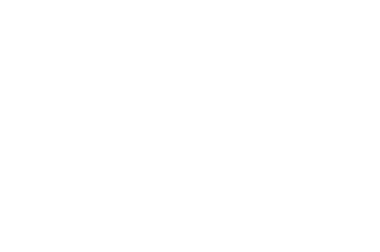

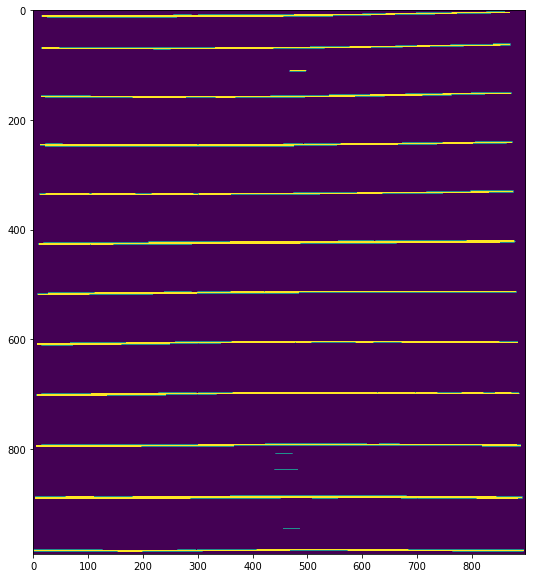

In [23]:
show_img(img)

In [78]:
filepath   = '/Users/kd/Workspace/python/github/handwriting-recognition/data/output/IMG_3862/boxes/0_1_IMG_3862/6_1_0_1_IMG_3862.jpg'
output_dir = '/Users/kd/Workspace/python/github/handwriting-recognition/data/output/IMG_3862/letters'



In [77]:
extract_box_letters(filepath, output_dir)

found (2) letters in [6_1_0_1_IMG_3862.jpg]


In [82]:
image      = cv2.imread(filepath, cv2.IMREAD_COLOR)

gray_img, bw_img = get_gray_and_bw_image(filepath)
# find contours and get the external one
contours  = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours  = contours[0] if len(contours) == 2 else contours[1]
print(len(contours))
c = []
a = []
for index, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    if w > 3 and w < 60 and h > 20:
        c.append(contour)
        a.append(w*h)

print(sorted(a, reverse=True)[:10])
print(len(c))

# x, y, w, h    = cv2.boundingRect(c[1])
# a = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
a = cv2.drawContours(image, c, -1, (0, 255, 0), 3)


1365
[2914, 2050]
2


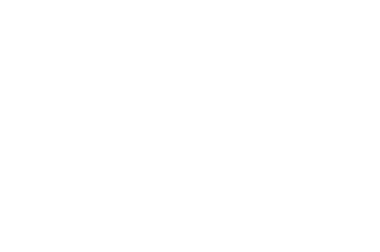

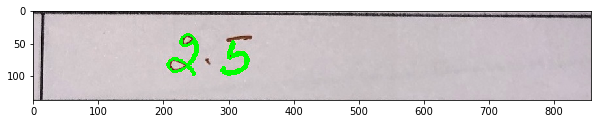

In [83]:
show_img(image)